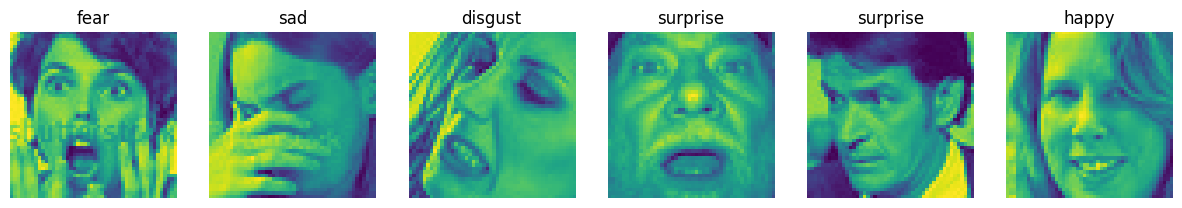

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

def visualize_raw_samples(directory, n=6):
    fig, axs = plt.subplots(1, n, figsize=(15, 3))
    for i in range(n):
        label = random.choice(os.listdir(directory))
        image_file = random.choice(os.listdir(os.path.join(directory, label)))
        image_path = os.path.join(directory, label, image_file)
        image = Image.open(image_path)
        
        axs[i].imshow(image)
        axs[i].set_title(label)
        axs[i].axis('off')

directory_path = '/kaggle/input/fer2013/train/'
visualize_raw_samples(directory_path)


In [2]:
import os
from collections import Counter

def analyze_label_distribution(directory):
    labels = []
    for label in os.listdir(directory):
        images = os.listdir(os.path.join(directory, label))
        labels.extend([label] * len(images))
    
    label_counts = Counter(labels)
    return label_counts

directory_path = '/kaggle/input/fer2013/train/'
label_distribution = analyze_label_distribution(directory_path)
print(label_distribution)


Counter({'happy': 7215, 'neutral': 4965, 'sad': 4830, 'fear': 4097, 'angry': 3995, 'surprise': 3171, 'disgust': 436})


In [3]:
# from PIL import Image

# def find_corrupt_images(directory):
#     corrupt_files = []
#     for label in os.listdir(directory):
#         image_files = os.listdir(os.path.join(directory, label))
#         for image_file in image_files:
#             try:
#                 with Image.open(os.path.join(directory, label, image_file)) as img:
#                     img.verify()
#             except (IOError, SyntaxError) as e:
#                 corrupt_files.append(os.path.join(directory, label, image_file))
#     return corrupt_files

# directory_path = '/kaggle/input/fer2013/train/'
# corrupt_images = find_corrupt_images(directory_path)
# print(f"Found {len(corrupt_images)} corrupt images")


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split

class FacialExpressionsDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = []
        self.labels = []

        for label in os.listdir(directory):
            for image_file in glob.glob(os.path.join(directory, label, '*.jpg')):
                self.images.append(image_file)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        label_to_idx = {'happy': 0, 'sad': 1, 'angry': 2, 'disgust': 3, 'fear': 4, 'surprise': 5, 'neutral': 6}
        label_idx = label_to_idx[label]

        return image, label_idx

transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.507395516207, ),(0.255128989415, ))
])

train_dataset = FacialExpressionsDataset(directory='/kaggle/input/fer2013/train/', transform=transform)
test_dataset = FacialExpressionsDataset(directory='/kaggle/input/fer2013/test/', transform=transform)


val_size = int(len(train_dataset) * 0.45)
train_size = len(train_dataset) - val_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, drop_last=True)

In [5]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 16 00:12:24 2020

@author: NAT
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name, num_classes, input_size, hidden_size, num_layers):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 7)
        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
        # Attention layers
        self.attention = nn.Linear(hidden_size * 2, hidden_size)  # Watt
        self.attention_vector = nn.Linear(hidden_size, 1)  # Vatt
        self.attention_activation = nn.Tanh()
        
        # Fusion and fully connected layers
        self.fusion_size = 512 + hidden_size * 2  # VGG features size (512) + LSTM attended features size
        self.dense1 = nn.Linear(self.fusion_size, 128)
        self.relu = nn.ReLU()
        self.output = nn.Linear(128, num_classes)

    def forward(self, x):

        vgg_features = self.features(x)
        vgg_features = vgg_features.view(vgg_features.size(0), -1)

        # LSTM and attention
        x_clone = x.clone()  # Clone the input tensor to avoid modifying the original tensor
        output, (hidden, cell) = self.lstm(x_clone.view(x_clone.size(0), -1, x_clone.size(2) * x_clone.size(3)))
        output = output.view(output.size(0), -1)  # Now output is [32, 256]

#         print(output.size(), vgg_features.size())
        fused_features = torch.cat((vgg_features, output), dim=1)

        # Dense layers
        hdense = self.relu(self.dense1(fused_features))
        x = self.output(hdense)
        return x 

    def _make_layers(self, cfg):
        layers = []
        in_channels = 1
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [6]:
num_classes = 7
input_size = 48*48
hidden_size = 128
num_layers = 7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = DCRAN(input_size, hidden_size, num_layers, num_classes, dropout_rate).to(device)
model = VGG('VGG19', num_classes, input_size, hidden_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
def validate_model(model, criterion, data_loader):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            
            running_loss += loss.item()
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            
    avg_loss = running_loss / len(data_loader)
    avg_acc = correct_predictions / total_predictions * 100
    return avg_loss, avg_acc

def train_and_validate_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    best_accuracy = 0.0
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_predictions / total_predictions * 100
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        val_loss, val_acc = validate_model(model, criterion, val_loader)
        test_loss, test_acc = validate_model(model, criterion, test_loader)

        
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%'
              f'Test loss: {test_loss:4f}, Test acc: {test_acc:.2f}%')

        if test_acc > best_accuracy:
            best_accuracy = test_acc
            torch.save(model.state_dict(), 'best_model.pth')

    print('Finished Training')
    return train_losses, train_accuracies, val_losses, val_accuracies

train_losses, train_accuracies, val_losses, val_accuracies = train_and_validate_model(
    model, criterion, optimizer, train_loader, val_loader, num_epochs=40)


Epoch 1/40, Train Loss: 1.7832, Train Acc: 26.54%, Val Loss: 1.7277, Val Acc: 28.75%Test loss: 1.731546, Test acc: 28.78%
Epoch 2/40, Train Loss: 1.6819, Train Acc: 31.50%, Val Loss: 1.6876, Val Acc: 34.38%Test loss: 1.680225, Test acc: 34.00%
Epoch 3/40, Train Loss: 1.5510, Train Acc: 38.50%, Val Loss: 1.4724, Val Acc: 41.87%Test loss: 1.471800, Test acc: 42.79%
Epoch 4/40, Train Loss: 1.4453, Train Acc: 43.17%, Val Loss: 1.4314, Val Acc: 44.33%Test loss: 1.431547, Test acc: 43.75%
Epoch 5/40, Train Loss: 1.3880, Train Acc: 45.57%, Val Loss: 1.3612, Val Acc: 47.75%Test loss: 1.360884, Test acc: 48.09%
Epoch 6/40, Train Loss: 1.3228, Train Acc: 48.76%, Val Loss: 1.2621, Val Acc: 51.55%Test loss: 1.265999, Test acc: 51.35%
Epoch 7/40, Train Loss: 1.2767, Train Acc: 50.61%, Val Loss: 1.2301, Val Acc: 52.07%Test loss: 1.248581, Test acc: 51.44%
Epoch 8/40, Train Loss: 1.2396, Train Acc: 52.04%, Val Loss: 1.1955, Val Acc: 53.94%Test loss: 1.208933, Test acc: 53.15%
Epoch 9/40, Train Loss: 

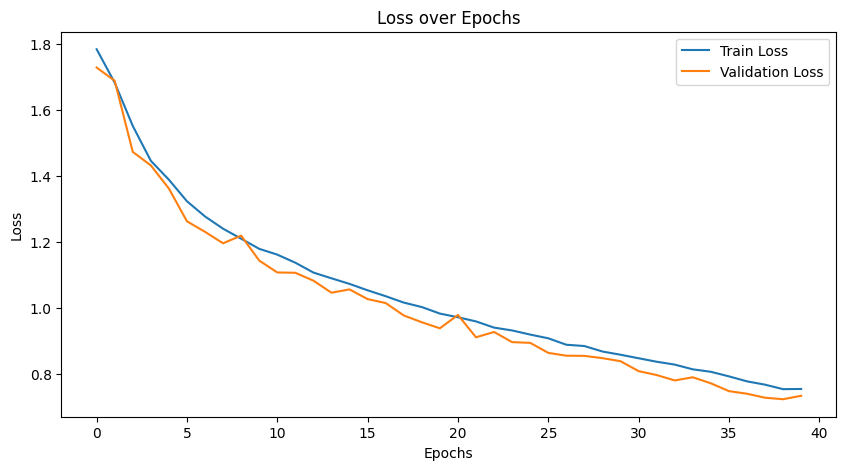

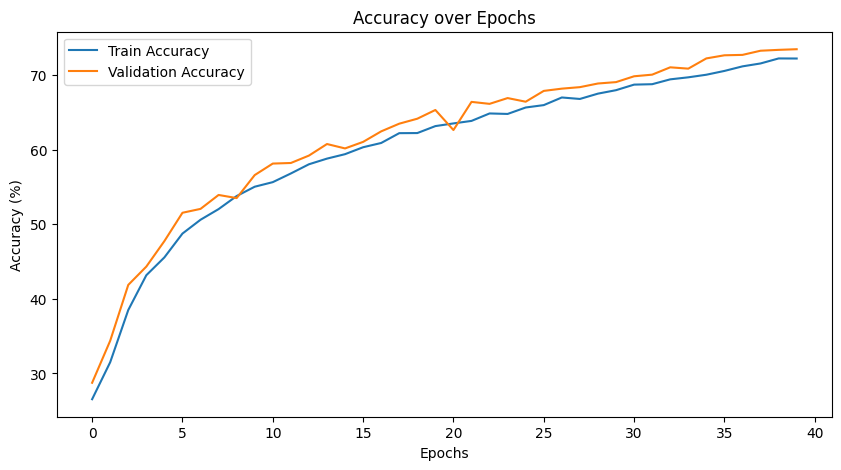

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

Accuracy of the model on the test images: 64.24%


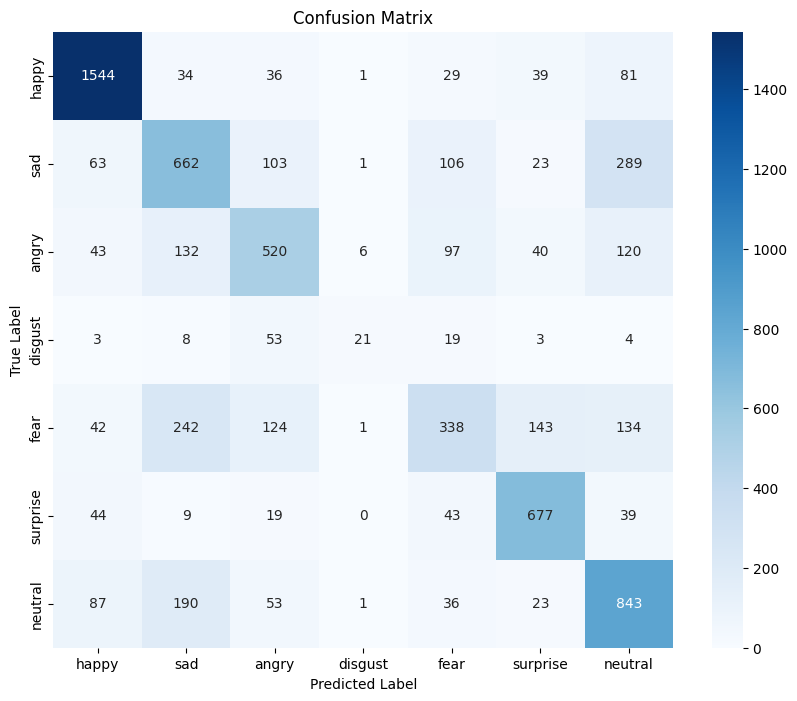

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_on_test(test_loader, model_path='/kaggle/working/best_model.pth'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = VGG('VGG19', num_classes, input_size, hidden_size, num_layers).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    correct = 0
    total = 0
    all_predicted = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_predicted.extend(predicted.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predicted)
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_to_idx.keys(), yticklabels=label_to_idx.keys())
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Assuming you have a dictionary for class labels
label_to_idx = {'happy': 0, 'sad': 1, 'angry': 2, 'disgust': 3, 'fear': 4, 'surprise': 5, 'neutral': 6}

# Evaluate the model on the test set
evaluate_on_test(test_loader)